<a href="https://colab.research.google.com/github/FilipSagalara/MasterThesis_SNN_frameworks/blob/main/Rockpool_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# - Install required packages
import sys
!{sys.executable} -m pip install --quiet rockpool tonic tqdm torch torchvision matplotlib

In [62]:
# - Basic imports
import torch
import torchvision
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Reproductibility
torch.manual_seed(0)

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange

from IPython.display import Image


precisions = []
accurecies = []
recalls = []
f1_scores = []
supports = []

In [63]:
import time

class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time

    def get_execution_time(self):
        return self.execution_time


    

# Display hardware info

In [64]:
import os
import re
cpu_info = os.popen('lscpu |grep \'Model name\'').read()
cpu_thread_info = os.popen('lscpu | grep \'Thread(s) per core\'').read()
cpu_core_info = os.popen('scpu | grep \'Core(s) per socket:\'').read()
cpu_cache_info = os.popen('lscpu | grep "L3 cache" ').read()
cpu_hz_info = os.popen('lscpu | grep "MHz"').read()
memory_available = os.popen('free -h --si | awk  \'/Mem:/{print $2}\'').read()
graphic_info = os.popen('nvidia-smi').read()

hardware_info = [cpu_info,cpu_thread_info, cpu_core_info, cpu_cache_info, cpu_hz_info, memory_available, graphic_info]
print(cpu_info)
print(cpu_thread_info)
print(cpu_core_info)
print(cpu_cache_info)
print(cpu_hz_info)
print(graphic_info)



Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz

Thread(s) per core:              2


L3 cache:                        38.5 MiB

CPU MHz:                         2200.220

Tue May 23 16:27:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    51W / 400W |   1587MiB / 40960MiB |      0%      Default |
|                               |                      |    

# Set batch size

In [65]:
# - Number of samples per batch
batch_size = 256

# Set training data & test data

In [66]:
# - Download and access the MNIST training dataset
train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# - Create a data loader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=False
)

# - Create a test dataset
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=batch_size,
)



In [67]:
def show_dataset(data, targets, num_of_images = 32):
  rows = 4
  cols = 8
  total_pictures = rows * cols
  plt.figure(figsize=(16,8))
  for img in range(total_pictures):
      plt.subplot(rows, cols, 1+img)
      plt.title(targets[img])
      plt.imshow(data[img])
      plt.axis('off')

# Show train data

In [68]:


train_images_to_show = train_data.data
train_labels_to_show = train_data.targets
# show_dataset(train_images_to_show, train_labels_to_show)

#Show test data

In [69]:
test_images_to_show = test_loader.dataset.data
test_labels_to_show = test_loader.dataset.targets
# show_dataset(test_images_to_show, test_labels_to_show)

In [70]:
# - Import the SNN modules from rockpool
from rockpool.nn.modules import LIF

# - Generate a spiking neuron
neuron = LIF(1)

# - Simulate this neuron for 1 sec with poisson spiking input z(t)
num_timesteps = int(1/neuron.dt)
input_z = 0.06 * (np.random.rand(num_timesteps) < 0.0125)
output, _, rec_dict = neuron(input_z, record = True)

# - Display the input, internal state and output events
# plt.figure()
# plt.plot(rec_dict['isyn'].squeeze(), label = '$I_s(t)$')
# plt.plot(rec_dict['vmem'].squeeze(), label = '$V_m(t)$')
# b, t, n = np.nonzero(output)
# plt.scatter(t, n, marker='|', c = 'k', label = '$o(t)$') 
# plt.plot([0, num_timesteps], [neuron.threshold] * 2, 'k:', label='$\Theta$')
# plt.xlabel('Time (dt)')
# plt.ylabel('$V_m$, $I_s$ (a.u.)')
# plt.legend();

# Define encoding functions

In [71]:
# - Define the temporal aspects of a data sample
num_timesteps = 100
dt = 10e-3

# - Extract the number of classes and input channels
num_classes = len(torchvision.datasets.MNIST.classes)
input_channels = train_data[0][0].numel()

# - Define a function to encode an input into a poisson event series
def encode_poisson(data: torch.Tensor, num_timesteps: int, scale: float = 0.1) -> torch.Tensor:
  num_batches, frame_x, frame_y = data.shape
  data = scale * data.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1))
  return (torch.rand(data.shape) < (data * scale)).float()

# - Define a function to encode the network target
def encode_class(class_idx: torch.Tensor, num_classes: int, num_timesteps: int) -> torch.Tensor:
  num_batches = class_idx.numel()
  target = torch.nn.functional.one_hot(class_idx, num_classes = num_classes)
  return target.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1)).float()

In [72]:
# - Get one sample
frame, class_idx = train_data[0]

# - Encode the input and targets
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

# # - Plot the poisson input for this sample
# plt.figure()
# b, t, n = torch.nonzero(data, as_tuple = True)
# plt.scatter(t * dt, n, marker = '|')
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Input')

# # - Plot the target event series for this sample
# b, t, n = torch.nonzero(target, as_tuple = True)
# plt.figure()
# plt.scatter(t * dt, n, marker = '|')
# plt.ylim([-1, num_classes+1])
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Target');

#Define network

In [73]:
# - Import network packages
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Define a simple network
num_hidden = 64
tau_mem = Constant(100e-3)
tau_syn = Constant(50e-3)
threshold = Constant(1.)
bias = Constant(0.)

# - Define a two-layer feed-forward SNN
snn = Sequential(
    LinearTorch((input_channels, num_hidden)),
    LIFTorch(num_hidden, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),

    LinearTorch((num_hidden, num_classes)),
    LIFTorch(num_classes, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt)
)
print(snn)

TorchSequential  with shape (784, 10) {
    LinearTorch '0_LinearTorch' with shape (784, 64)
    LIFTorch '1_LIFTorch' with shape (64, 64)
    LinearTorch '2_LinearTorch' with shape (64, 10)
    LIFTorch '3_LIFTorch' with shape (10, 10)
}


In [74]:
# - Simulate the untrained network, record internal state
output, _, rec_dict = snn(data, record = True)

# # - Display the internal state and output
# plt.plot(rec_dict['1_LIFTorch']['vmem'][0].detach());
# plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
# plt.ylim([-2.1, 1.1])
# plt.xlabel('Time (dt)')
# plt.ylabel('$V_m$ (a.u.)')
# plt.title('Hidden $V_m$')

# plt.figure()
# plt.plot(rec_dict['3_LIFTorch']['vmem'][0].detach());
# plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
# plt.ylim([-2.1, 1.1])
# plt.xlabel('Time (dt)')
# plt.ylabel('$V_m$ (a.u.)')
# plt.title('Output $V_m$')

# plt.figure()
# t, n = torch.nonzero(rec_dict['3_LIFTorch_output'][0].detach(), as_tuple = True)
# plt.scatter(t, n, marker = '|', label='Output events')
# plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
# plt.ylim([-1, num_classes+1])
# plt.xlim([-1, num_timesteps+1])
# plt.xlabel('Time (dt)')
# plt.ylabel('Channel')
# plt.title('Output (events)')
# plt.legend();

In [75]:
from torch.optim.adam import Adam

# - Initialise the optimizer with the network parameters
optimizer = Adam(snn.parameters().astorch())

# Use GPU

In [76]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define train

In [77]:
def train(model, device, train_loader, optimizer):
  # - Prepare model for training
  model.train()
  losses = []
  accuracy = []
  time_per_epochs = []
  
  # Count correct predictions in training
  correct = 0
  # - Loop over the dataset for this epoch
  for data, class_idx in tqdm(train_loader, leave=False, desc='Training', unit='batch'):
    # - Encode input and target
    data = encode_poisson(data.squeeze(), num_timesteps)
    target = encode_class(class_idx, num_classes, num_timesteps)

    # - Zero gradients, simulate model
    optimizer.zero_grad()
    output, _, _ = model(data.to(device))

    # - Compute MSE loss and perform backward pass
    loss = torch.nn.functional.mse_loss(output, target.to(device))
    loss.backward()
    optimizer.step()
    
    # - Compute Accuracy 
    pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
    correct += pred.eq(class_idx.view_as(pred)).sum().item()
    
    # - Keep track of the losses
    losses.append(loss.item())

  acc = 100.0 * correct / len(test_loader.dataset)




  return losses

# Define test function 

In [78]:


def test(model, device, test_loader):
    # - Prepare model for evaluation
    model.eval()
    test_loss = 0
    correct = 0

    preds_ints = [] #predicted numbers
    true_ints = [] #true numbers

  
    with torch.no_grad():
      # - Loop over the dataset
      for data, class_idx in tqdm(test_loader, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        input = encode_poisson(data.squeeze(), num_timesteps)
        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Evaluate the model
        output, _, _ = model(input.to(device))

        # - Compute loss and prediction
        test_loss += torch.nn.functional.mse_loss(output, target.to(device)).item()
        pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
        correct += pred.eq(class_idx.view_as(pred)).sum().item()


        # Compute confusion matrix
        class_to_preds_format = class_idx.view_as(pred)
        for ix, class_num in enumerate(class_to_preds_format):
          # print("Predicted {p} true {class_num}".format(p = pred[ix], class_num = class_num))
          # get num
          predtensor_to_int = int(pred[ix][0])
          classtensor_to_int = int(class_num)
          preds_ints.append(predtensor_to_int)
          true_ints.append(classtensor_to_int)
    
    
    #Create confusion matrix
    cm = confusion_matrix(y_true=true_ints, y_pred = preds_ints)


    #Calculate loss
    test_loss /= len(test_loader.dataset)
    # Calculate accuracy
    accuracy = 100.0 * correct / len(test_loader.dataset)
    


    return test_loss, accuracy, cm, preds_ints, true_ints

# Initial loss accuracy precision etc

In [79]:
# - Initial loss and accuracy
test_loss, test_acc, cm, predicted_ints, true_ints = test(snn.to(device), device, test_loader)
print(f'Initial test loss {test_loss}, accuracy {test_acc}%') 

#importing accuracy_score, precision_score, recall_score, f1_score
y_pred = predicted_ints
y_test = true_ints
target_names = ['0','1','2','3','4','5','6','7','8','9']


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=target_names))




Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Initial test loss 0.0004244152545928955, accuracy 8.79%

Accuracy: 0.09

Micro Precision: 0.09
Micro Recall: 0.09
Micro F1-score: 0.09

Macro Precision: 0.10
Macro Recall: 0.09
Macro F1-score: 0.08

Weighted Precision: 0.09
Weighted Recall: 0.09
Weighted F1-score: 0.08

Classification Report

              precision    recall  f1-score   support

           0       0.06      0.23      0.10       980
           1       0.05      0.02      0.02      1135
           2       0.08      0.02      0.03      1032
           3       0.11      0.20      0.14      1010
           4       0.09      0.03      0.04       982
           5       0.08      0.06      0.07       892
           6       0.15      0.11      0.13       958
           7       0.14      0.07      0.09      1028
           8       0.12      0.10      0.11       974
           9       0.07      0.05      0.06      1009

    accuracy                           0.09     10000
   macro avg       0.10      0.09      0.08     10000
we

# Set num of epochs

In [80]:
# - Train some epochs
num_epochs = 1

# Training

Training:   0%|          | 0/1 [00:00<?, ?epoch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

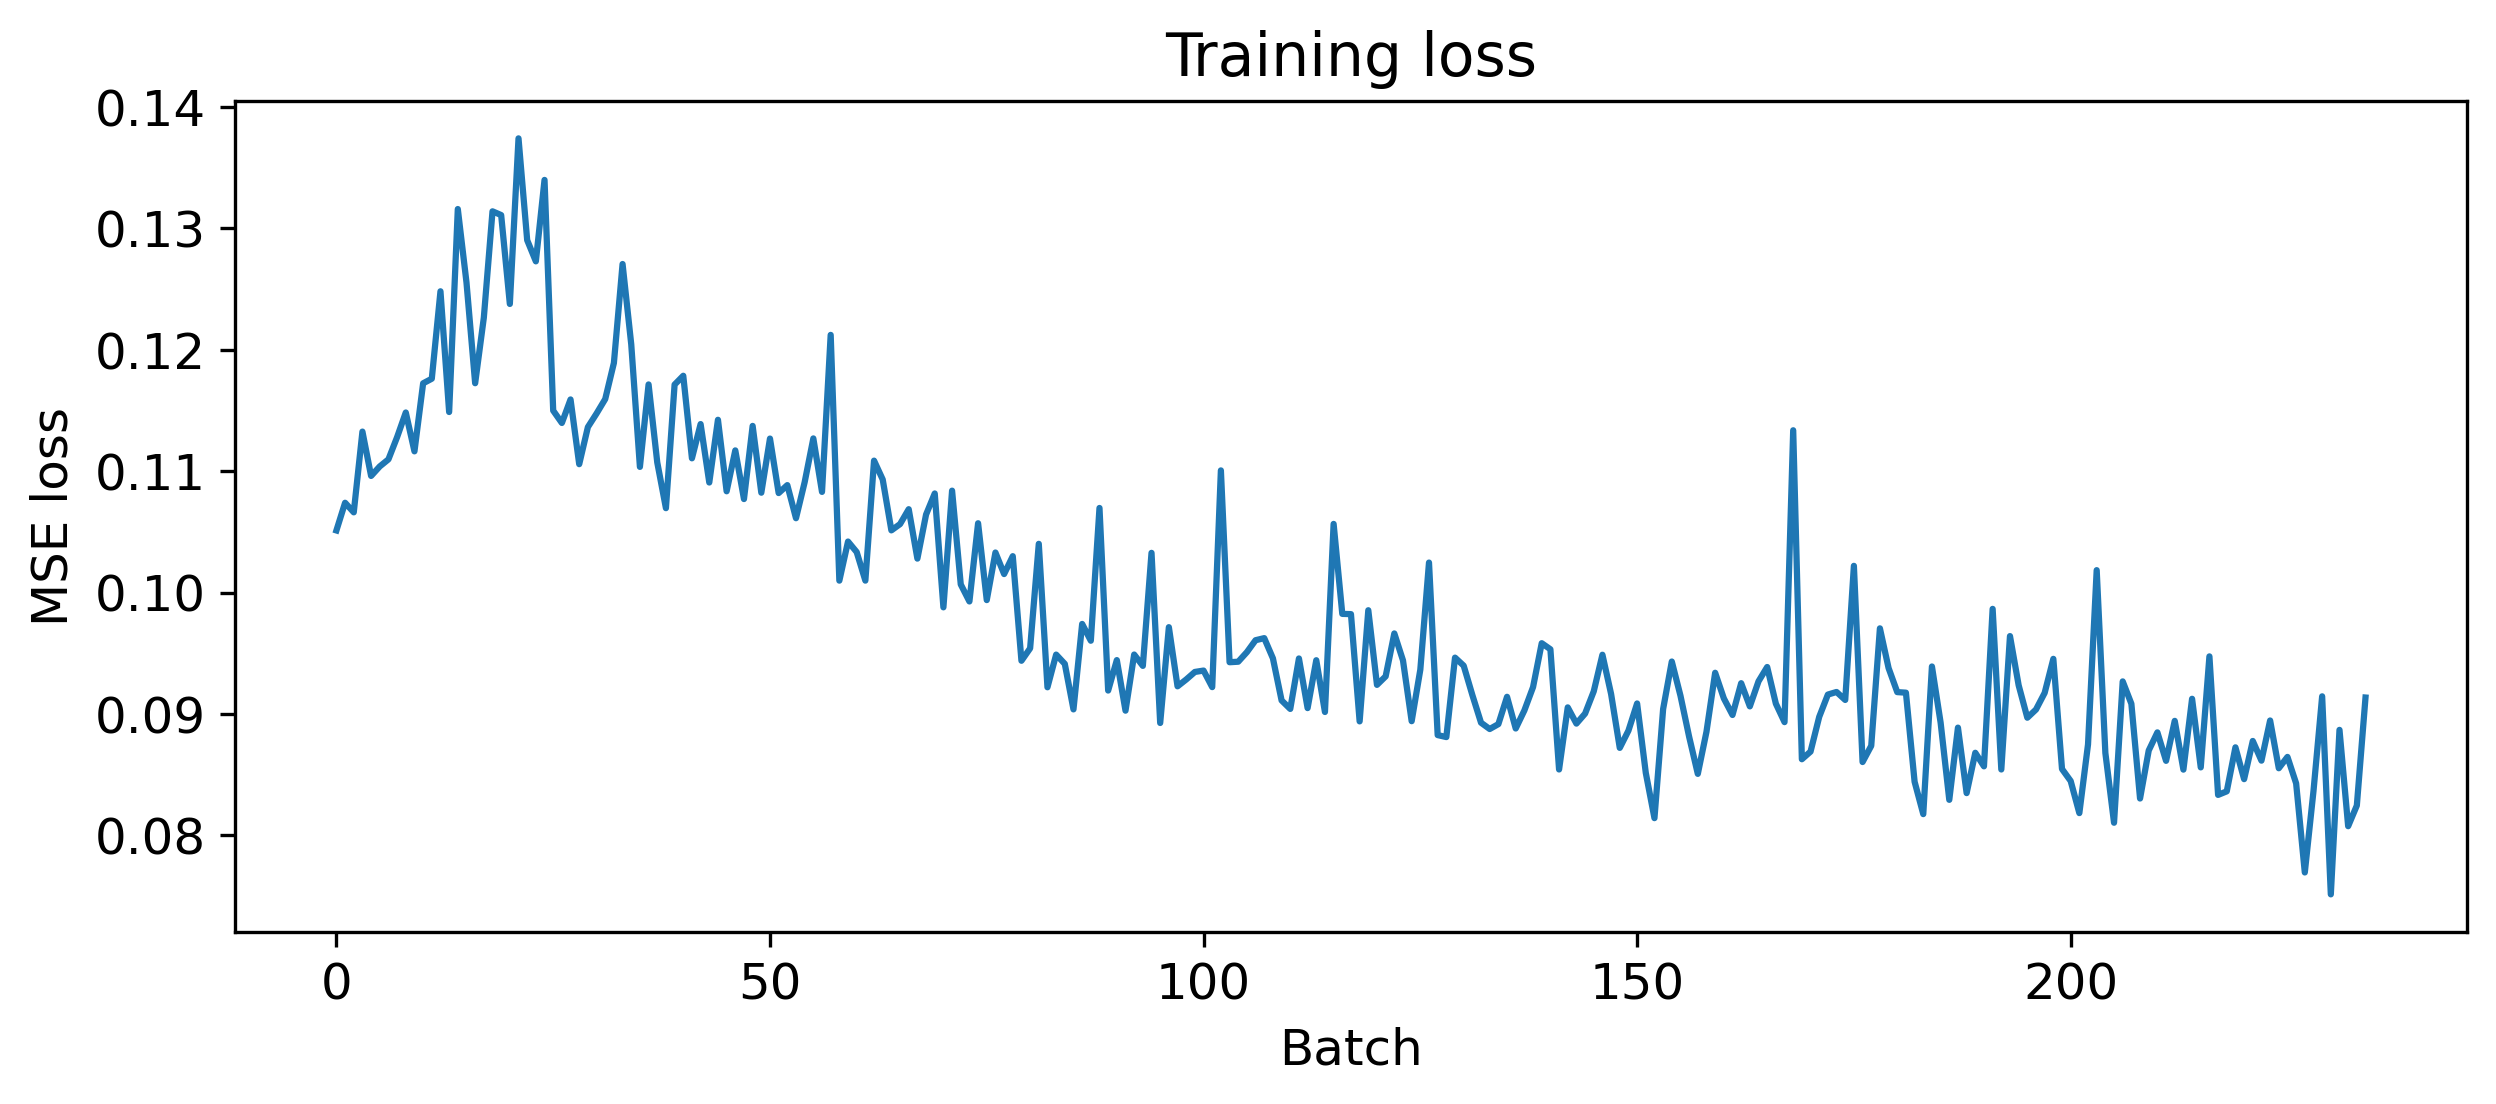

In [81]:
# Model metrics data
all_losses = []
all_accuracy_per_epoch = []
all_loss_per_epoch = []
all_precision_per_epoch = []

time_per_epoch = []


ep_loop = trange(num_epochs, desc='Training', unit='epoch')
for epoch in ep_loop:
  ep_loop.set_postfix(test_loss = test_loss, test_acc = f'{test_acc}%')
  with Timer() as t:
    losses = train(snn.to(device), device, train_loader, optimizer)
    
  #Get all losses
  all_losses.extend(losses)
  # - Get test loss and accuracy
  test_loss, test_acc, cm, predicted_ints, true_ints = test(snn.to(device), device, test_loader)
  # Get training accuracy per epoch
  all_accuracy_per_epoch.append(test_acc)
  # Get training loss per epoch
  all_loss_per_epoch.append(test_loss)
  # Get time per epoch
  time_per_epoch.append(t.get_execution_time())
  # Display confusion matrix



plt.plot(all_losses)
plt.xlabel('Batch')
plt.ylabel('MSE loss')
plt.title('Training loss');





#Display confusion matrix

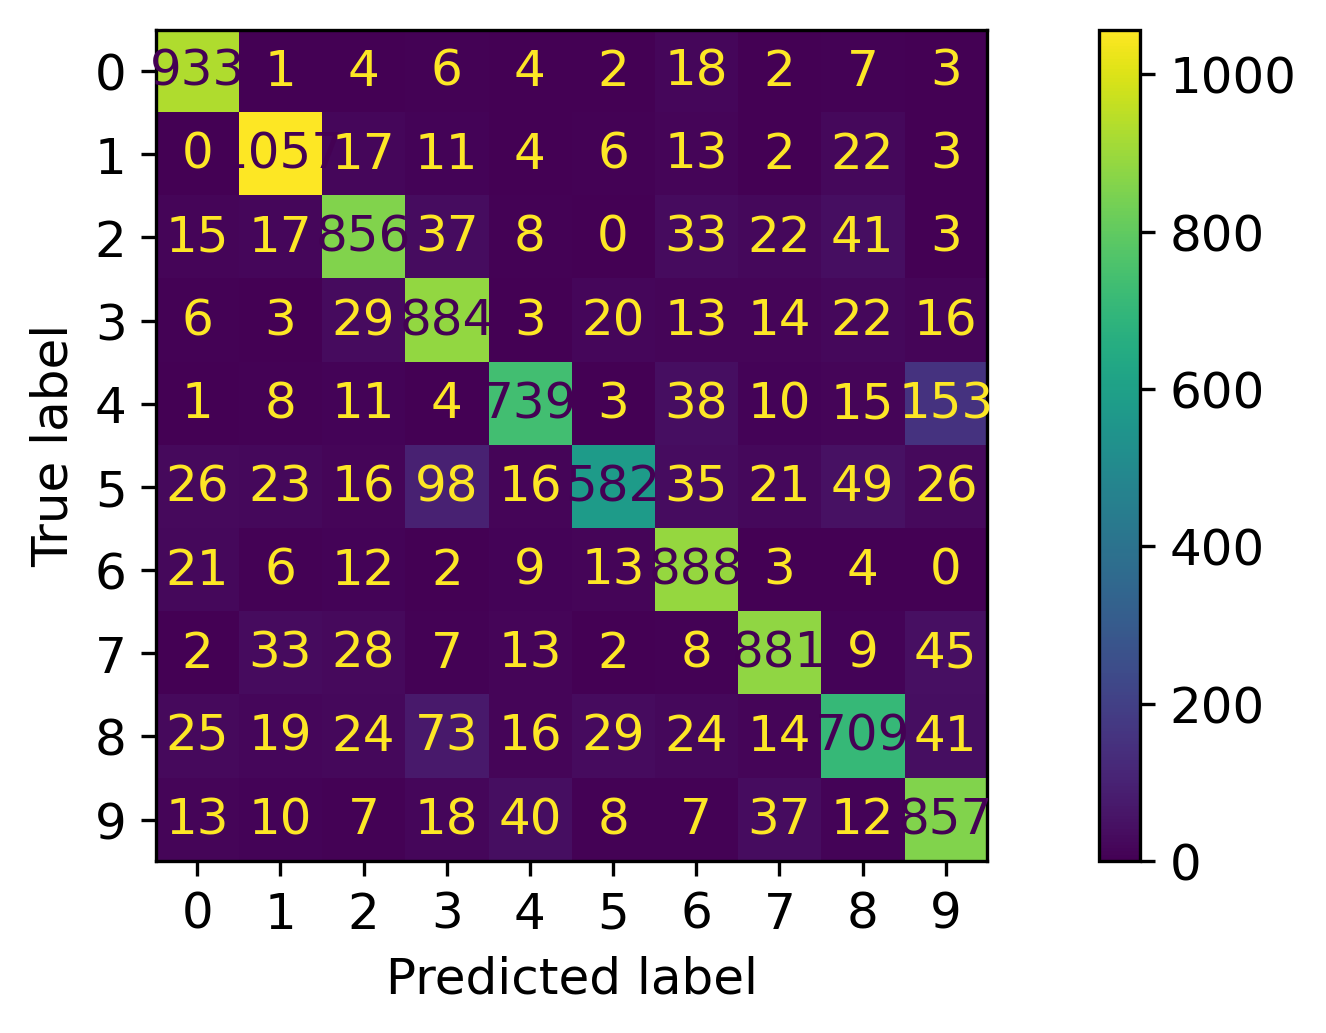

In [82]:
cm_display = ConfusionMatrixDisplay(cm).plot()

# cm_display = ConfusionMatrixDisplay(cm)
# all = sum(sum(cm))
# print(all)

# Compute precision (after training)


In [83]:
#importing accuracy_score, precision_score, recall_score, f1_score
y_pred = predicted_ints
y_test = true_ints
target_names = ['0','1','2','3','4','5','6','7','8','9']
precisions = []
recalls = []
f1_scores = []

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
classifi_report = classification_report(y_test, y_pred, target_names=target_names)
print(classifi_report)

#macro avg
macro_prec = precision_score(y_test, y_pred, average='macro')

macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1_score = f1_score(y_test, y_pred, average='macro')


precisions.append(macro_prec)
recalls.append(macro_recall)
f1_scores.append(macro_f1_score)


Accuracy: 0.84

Micro Precision: 0.84
Micro Recall: 0.84
Micro F1-score: 0.84

Macro Precision: 0.84
Macro Recall: 0.84
Macro F1-score: 0.83

Weighted Precision: 0.84
Weighted Recall: 0.84
Weighted F1-score: 0.84

Classification Report

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       980
           1       0.90      0.93      0.91      1135
           2       0.85      0.83      0.84      1032
           3       0.78      0.88      0.82      1010
           4       0.87      0.75      0.81       982
           5       0.88      0.65      0.75       892
           6       0.82      0.93      0.87       958
           7       0.88      0.86      0.87      1028
           8       0.80      0.73      0.76       974
           9       0.75      0.85      0.79      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.84     10000



# My functions

## Show training time per epoch

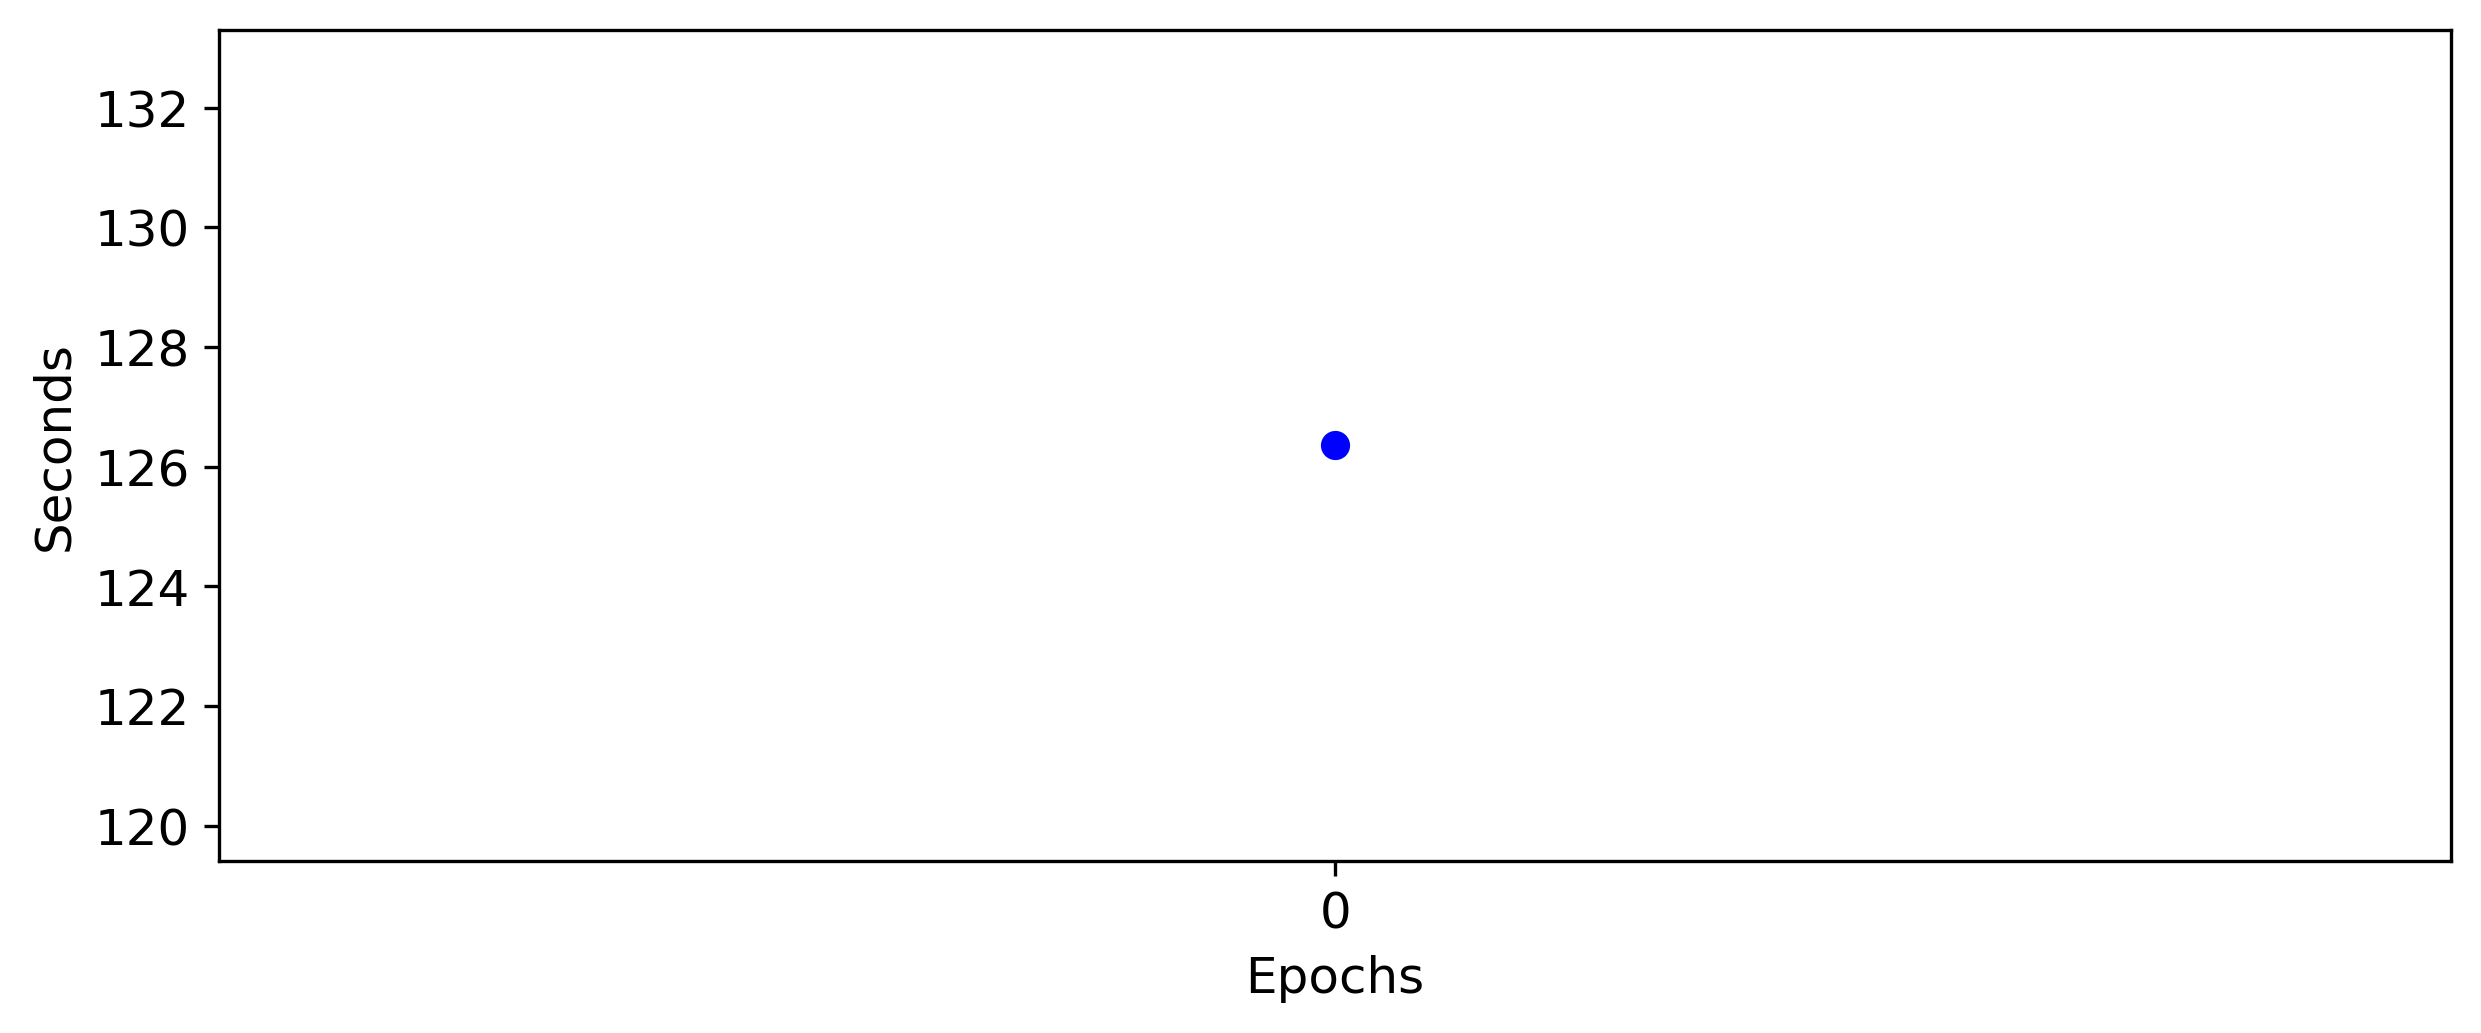

In [84]:
import matplotlib.pyplot as plt
import numpy as np
def show_training_time(time_per_epoch):
  y = np.array(time_per_epoch)
  x = np.array(range(0, len(time_per_epoch)))

  plt.plot(x,y, 'bo--')
  plt.xticks(ticks=x)
  plt.ylabel('Seconds')
  plt.xlabel('Epochs')
  plt.show()
    
show_training_time(time_per_epoch)

## Show training accuracy

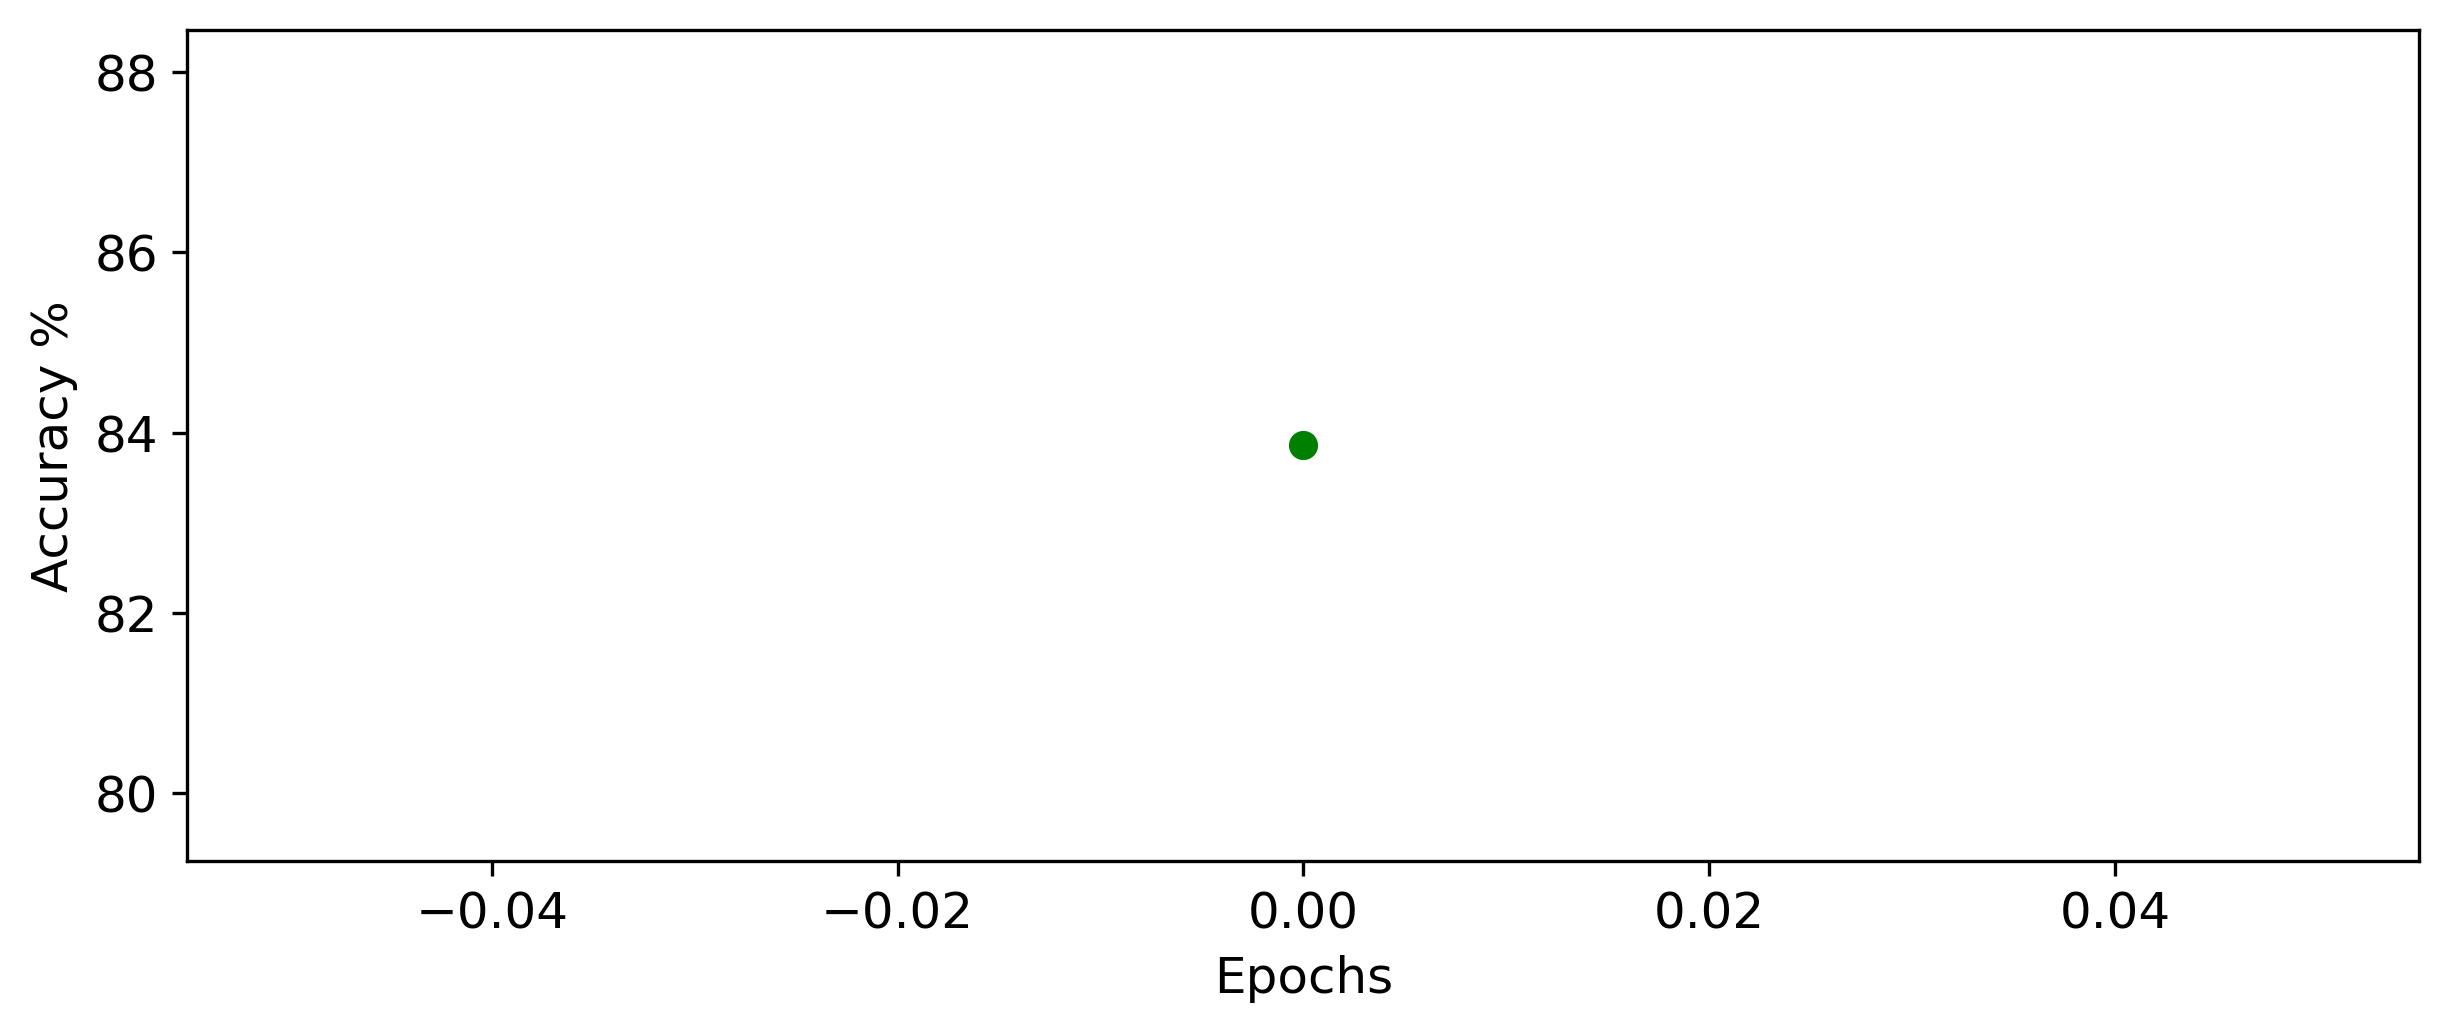

In [85]:
def show_training_accuracy(accuracy_per_epoch):
  in_percentage = [acc/100 for acc in accuracy_per_epoch]
  x= np.arange(len(in_percentage))
  # plt.scatter(x,accuracy_per_epoch)
  plt.plot(x,accuracy_per_epoch, 'go--')
  # plt.xticks(ticks=x)
  plt.ylabel('Accuracy %')
  plt.xlabel('Epochs')
  plt.show()
    

show_training_accuracy(all_accuracy_per_epoch)

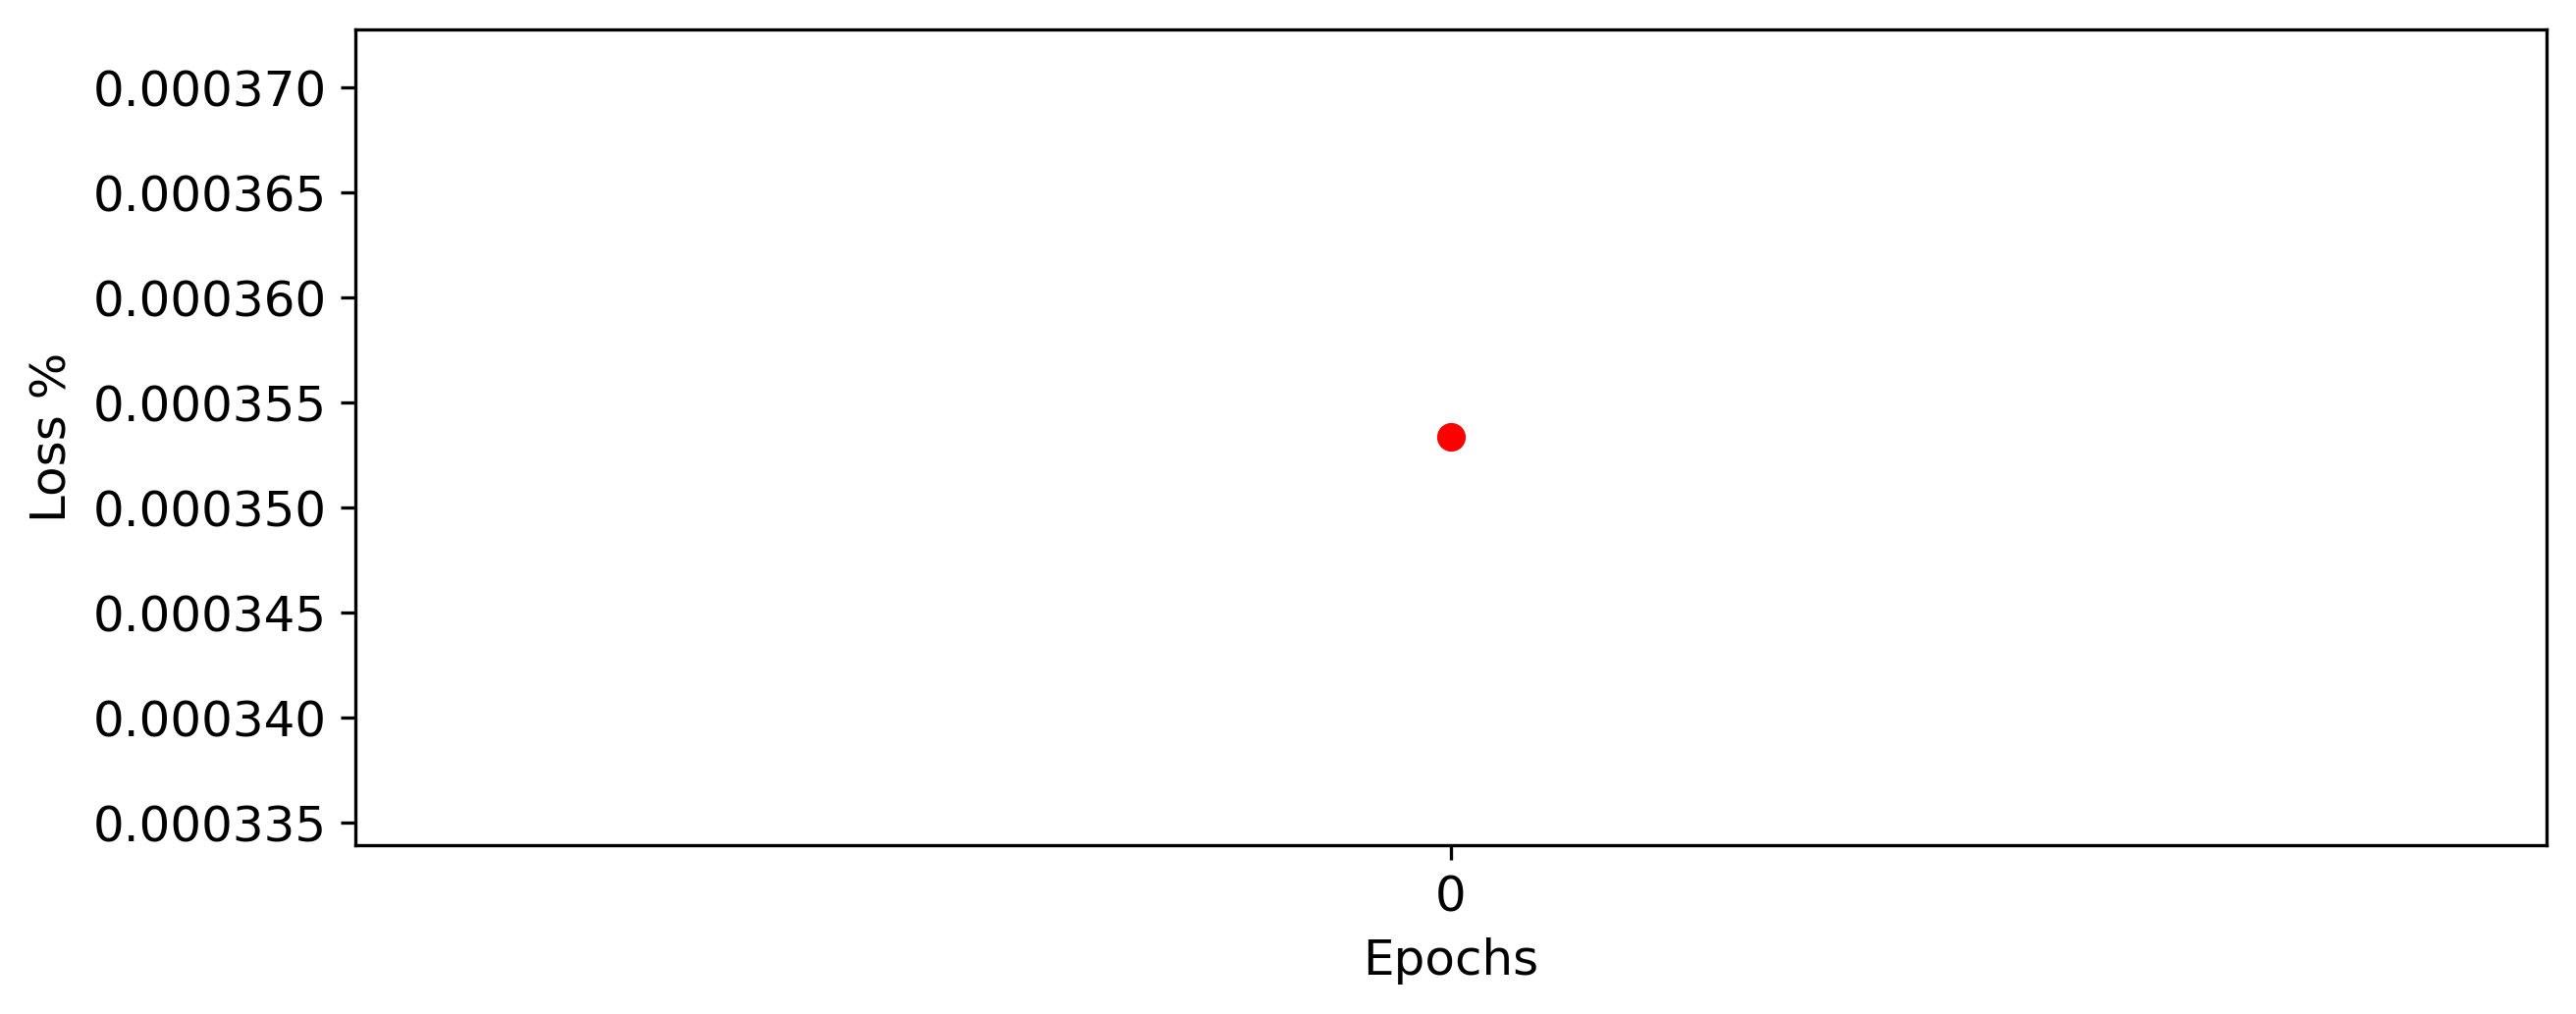

In [86]:
def show_training_loss(loss_per_epoch):
  in_percentage = [loss/100 for loss in loss_per_epoch]
  x= np.arange(len(in_percentage))
  # plt.scatter(x,loss_per_epoch)
  plt.plot(x,loss_per_epoch, 'ro--')
  plt.xticks(ticks=x)
  plt.ylabel('Loss %')
  plt.xlabel('Epochs')
  plt.show()
    
show_training_loss(all_loss_per_epoch)

## Final test accuracy and loss

In [87]:
# - Trained loss and accuracy
print(f'Final test loss {test_loss}, accuracy {test_acc}%')

Final test loss 0.00035335860997438433, accuracy 83.86%


In [88]:
# # - Pull a single test sample and display it
# frame, class_idx = train_data[1]
# data = encode_poisson(frame, num_timesteps)
# target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

# plt.figure(figsize=(1, 1))
# plt.imshow(frame[0])
# plt.xticks([])
# plt.yticks([])

# plt.figure()
# b, t, n = torch.nonzero(data, as_tuple = True)
# plt.scatter(t * dt, n, marker='|')
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Input')

# b, t, n = torch.nonzero(target, as_tuple = True)
# plt.figure()
# plt.scatter(t * dt, n, marker='|')
# plt.ylim([-1, num_classes+1])
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Target');

In [89]:
# # - Simulate the network with this sample
# output, _, _ = snn.cpu()(data)
# pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()

# # - Display the network output
# b, t, n = torch.nonzero(output, as_tuple=True)

# plt.scatter(t, n, marker='|', label='Output events')
# plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
# plt.plot(100, pred, '<', c='orange', markersize=20, label='Predicted class')
# plt.ylim([-1, num_classes+1])
# plt.xlim([-1, num_timesteps+1])
# plt.xlabel('Time (dt)')
# plt.ylabel('Channel')
# plt.title('Output (events)')
# plt.legend();

# Summary

In [90]:
# from tabulate import tabulate

# table = [ 
#          ['CPU/GPU', str(device) ], 
#          ['batch_size', batch_size],
#          ['num_of_epochs', num_epochs], 
#          ['all_accuracy_per_epoch', all_accuracy_per_epoch],
#          ['all_loss_per_epoch', all_loss_per_epoch],
#          ['time_per_epoch', time_per_epoch],
#          ['final_test_loss', test_loss],
#          ['final_test_accuracy', test_acc]]


# print(tabulate(table))
# import pandas as pd
# #Pandas dataframe
# d = {'acc_per_epoch': all_accuracy_per_epoch, 'loss_per_epoch': all_loss_per_epoch, 'time_per_epoch' : time_per_epoch, }
# df = pd.DataFrame(data=d)



# print(df)

# results_file = "Rockpool_{device}_batch_size_{batch}_num_of_epochs_{epochs}".format(device=device, batch=batch_size, epochs=num_epochs) + ".csv"

# df.to_csv(results_file, index=False)


# Save to drive

In [93]:

final_dict = {
    "Hardware" : "",
    "ep" : 0,
    "batch" : 0,
    "all_accuracy_per_epoch" : [],
    "all_loss_per_epoch" : [],
    "macro_prec" : [],
    "macro_recall" : [],
    "macro_f1_score" : [],
    "cm" : [],
    "time_training" : [], #per epoch
    "full_time" : 0, #seconds
    "class_report" : ""
}
# # fill dict
final_dict["Hardware"] = "GPU A100"
final_dict["ep"] = num_epochs
final_dict["batch"] = batch_size
final_dict["all_accuracy_per_epoch"].append(all_accuracy_per_epoch)
final_dict["all_loss_per_epoch"].append(all_loss_per_epoch)

final_dict["macro_prec"].append(precisions)
final_dict["macro_recall"].append(recalls)
final_dict["macro_f1_score"].append(f1_scores)

final_dict["cm"].append(cm)
final_dict["time_training"].append(time_per_epoch)
final_dict["full_time"] = sum(time_per_epoch)
final_dict["class_report"] = classifi_report
print(final_dict)

from google.colab import drive
drive.mount('/content/drive/')
summary_file = pd.DataFrame(final_dict)


print(summary_file)
summary_file.to_excel("/content/drive/My Drive/Rockpool.xlsx")




{'Hardware': 'GPU A100', 'ep': 1, 'batch': 256, 'all_accuracy_per_epoch': [[83.86]], 'all_loss_per_epoch': [[0.00035335860997438433]], 'macro_prec': [[0.8408080249812787]], 'macro_recall': [[0.8354252304390763]], 'macro_f1_score': [[0.834859980065523]], 'cm': [array([[ 933,    1,    4,    6,    4,    2,   18,    2,    7,    3],
       [   0, 1057,   17,   11,    4,    6,   13,    2,   22,    3],
       [  15,   17,  856,   37,    8,    0,   33,   22,   41,    3],
       [   6,    3,   29,  884,    3,   20,   13,   14,   22,   16],
       [   1,    8,   11,    4,  739,    3,   38,   10,   15,  153],
       [  26,   23,   16,   98,   16,  582,   35,   21,   49,   26],
       [  21,    6,   12,    2,    9,   13,  888,    3,    4,    0],
       [   2,   33,   28,    7,   13,    2,    8,  881,    9,   45],
       [  25,   19,   24,   73,   16,   29,   24,   14,  709,   41],
       [  13,   10,    7,   18,   40,    8,    7,   37,   12,  857]])], 'time_training': [[126.35461640357971]], 'full